In [1]:
# setup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import requests
import calendar
import geopandas as gpd
import os.path as os
import scipy.stats
import seaborn.palettes
import seaborn.utils
import sys
from census import Census
from us import states
from sklearn.metrics import precision_recall_fscore_support
import config

root= r"C:/Users/Jennah/Desktop/Code/machine-learning-final"
inp= os.join(root, "data", "3_clean")
interm= os.join(root, "data", "2_intermediate")

plots= os.join(root, "code", "plots")

In [5]:
from pydrive.auth import GoogleAuth

gauth = GoogleAuth()
gauth.LocalWebserverAuth() # Creates local webserver and auto handles authentication.

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=570719947456-53haph7mjc317oel1ujh0kmjbfd499jf.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [6]:
# files in clean data google drive
from pydrive.drive import GoogleDrive
drive = GoogleDrive(gauth)
fileList = drive.ListFile({'q': "'1jxSI_nq32-W9kPHKvQkzuNGJ5aIBD2j2' in parents and trashed=false"}).GetList()
for file in fileList:
  print('Title: %s, ID: %s' % (file['title'], file['id']))
  # Get the folder ID that you want
  if(file['title'] == "To Share"):
      fileID = file['id']

Title: analysis_bbl.csv, ID: 1yYX-ROr1c7fzcQiG6NZ1sh7Ko5gqr_4G
Title: borobox_convex_hull.geojson, ID: 1SzBNj3Ba-v9MEwuCkZT9e9iAwVYUqx8r
Title: analysis_bbl_noacs.csv, ID: 1h-tDpBSslfzqzsJe1ny_ujDnr68RKry3
Title: analysis_box.csv, ID: 1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy


## Load building level analysis file

In [7]:
df_bbl = drive.CreateFile({'id': '1yYX-ROr1c7fzcQiG6NZ1sh7Ko5gqr_4G'})
df_bbl.GetContentFile('analysis_bbl.csv')  

df_bbl= pd.read_csv('analysis_bbl.csv').drop(["Unnamed: 0"], axis = 1)
df_bbl.head()

df_bbl.drop(df_bbl.loc[df_bbl["bbl"].isna()].index, inplace = True)

# (1) Decision Trees and Random Forest Models

In [8]:
assert df_bbl.loc[:, "vacate_ind"].isna().sum() == 0
df_bbl.loc[:, "num_vac_orders"]= df_bbl.loc[:, "num_vac_orders"].fillna(0)

In [9]:
print(df_bbl.columns)
df_bbl.describe()

Index(['borough', 'bbl', 'cd', 'tract2010', 'zipcode', 'address', 'bldgclass',
       'landuse', 'ownertype', 'ownername',
       ...
       'pctnhaian', 'pctnhasian', 'pctnhhawainpi', 'pctnhother',
       'pctnhtwoplus', 'pctownerocch', 'pctrentocch', 'crowding',
       'crowdingrenter', 'geofips_recode'],
      dtype='object', length=156)


,bbl,cd,tract2010,zipcode,landuse,lotarea,bldgarea,numbldgs,numfloors,unitsres,...,pctnhaian,pctnhasian,pctnhhawainpi,pctnhother,pctnhtwoplus,pctownerocch,pctrentocch,crowding,crowdingrenter,geofips_recode
count,7.650260e+05,765026.000000,765023.000000,765026.000000,765026.000000,7.650260e+05,7.650260e+05,765026.000000,765026.000000,765026.000000,...,765026.000000,765026.000000,765026.000000,765026.000000,765026.000000,765026.000000,765026.000000,765026.000000,765026.000000,7.650260e+05
mean,3.548735e+09,357.696362,9565.767255,11026.331800,1.421477,3.812014e+03,5.051030e+03,1.324975,2.443933,4.689669,...,0.181251,15.733092,0.033562,1.119457,1.962135,50.197532,49.802468,8.170173,10.205338,3.541768e+06
std,1.003515e+09,98.073102,26807.879379,464.282752,0.842764,2.318736e+04,3.520154e+04,2.726640,1.676083,42.058995,...,0.705180,17.564380,0.269543,3.038141,2.060742,24.959007,24.959007,6.977816,9.218895,9.994487e+05
min,1.000070e+09,0.000000,1.000000,0.000000,1.000000,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000201e+06
25%,3.036730e+09,307.000000,222.000000,10467.000000,1.000000,2.000000e+03,1.440000e+03,1.000000,2.000000,1.000000,...,0.000000,2.887910,0.000000,0.000000,0.490998,29.103943,27.593699,3.289474,3.183024,3.030100e+06
50%,4.012680e+09,403.000000,504.000000,11223.000000,1.000000,2.500000e+03,2.020000e+03,1.000000,2.000000,2.000000,...,0.000000,8.355388,0.000000,0.000000,1.404125,50.627615,49.372385,6.207928,8.142494,4.010200e+06
75%,4.107290e+09,412.000000,1139.000000,11372.000000,2.000000,4.000000e+03,2.923000e+03,2.000000,2.750000,2.000000,...,0.000000,23.870968,0.000000,0.778210,2.694064,72.406301,70.896057,11.000000,14.855072,4.092200e+06
max,5.080500e+09,503.000000,157903.000000,12345.000000,4.000000,1.225343e+07,1.354011e+07,1807.000000,98.000000,19201.000000,...,25.050100,91.605249,7.191448,31.090573,20.276498,100.000000,100.000000,100.000000,100.000000,5.032300e+06


In [10]:
df_bbl= pd.get_dummies(df_bbl, columns=["borough"])
borocols= ["borough_" + x for x in ["BK", "BX", "MN", "QN", "SI"]]

In [11]:
# define predictors
df_bbl.columns
predictors = ["lotarea", "bldgarea", "numbldgs", "numfloors", "unitsres", "unitstotal", "assessland",
             "assesstot", "exempttot", "yearbuilt", "holc_AB", "holc_CD", "holc_D",
             "tot_hpd_vio", "hpd_fire_vio", "hpd_b_c_vio",
             "viol_count_per_unit", "hpd_fire_vio_per_unit", "hpd_b_c_vio_per_unit",
             "AL", "NB", "average_energy_usage", "average_energy_usage_mi"]
predictors_acs= df_bbl.columns[df_bbl.columns.get_loc("totpop"):df_bbl.columns.get_loc("crowdingrenter") + 1].tolist()
predictors_full= predictors + predictors_acs
predictors_full

['lotarea',
 'bldgarea',
 'numbldgs',
 'numfloors',
 'unitsres',
 'unitstotal',
 'assessland',
 'assesstot',
 'exempttot',
 'yearbuilt',
 'holc_AB',
 'holc_CD',
 'holc_D',
 'tot_hpd_vio',
 'hpd_fire_vio',
 'hpd_b_c_vio',
 'viol_count_per_unit',
 'hpd_fire_vio_per_unit',
 'hpd_b_c_vio_per_unit',
 'AL',
 'NB',
 'average_energy_usage',
 'average_energy_usage_mi',
 'totpop',
 'popdens',
 'areasqmile',
 'males',
 'females',
 'pop18under',
 'pop18_34',
 'pop35_64',
 'pop65plus',
 'pophispanic',
 'popnhwhite',
 'popnhblack',
 'popnhaian',
 'popnhasian',
 'popnhhawainpi',
 'popnhother',
 'popnhtwoplus',
 'housing',
 'housingoccupied',
 'renterhousing',
 'oc_halfless',
 'oc_half_1',
 'oc_1_onehalf',
 'oc_onehalf_2',
 'oc_2plus',
 'roc_halfless',
 'roc_half_1',
 'roc_1_onehalf',
 'roc_onehalf_2',
 'roc_2plus',
 'medianyearbuilt',
 'mediangrossrent',
 'medianhhincome',
 'gini',
 'year',
 'pct18under',
 'pct18_34',
 'pct35_64',
 'pct65plus',
 'pcthispanic',
 'pctnhwhite',
 'pctnhblack',
 'pctnhaia

In [12]:
outcomes= ["vacate_ind", "num_vac_orders"]
df_bbl[outcomes].head()

# very small percentage of the data has had a fire
df_bbl[outcomes[0]].mean()

0.003403805883721599

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X = df_bbl.loc[:, predictors_full].fillna(0)
y = df_bbl.loc[:, "vacate_ind"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=999)

dt = DecisionTreeClassifier(max_depth=10)
dt.fit(X_train, y_train)
y_predict = dt.predict(X_test)

# accuracy is very high, but that is bc most are 0s!
accuracy= (y_predict == y_test).value_counts(normalize=True)[True]
accuracy

0.9962615682242013

__Area under the curve__

In [14]:
from sklearn.metrics import roc_auc_score
dt=DecisionTreeClassifier(random_state = 99)
dt.fit(X_train,y_train)
# predict_proba predicts the probability of each class rather than just the most likely class
pred=dt.predict_proba(X_test)[:,1] # predicted probability of y = 1
roc_auc_score(np.array(y_test),pred)

0.56441374489671

In [15]:
# vs. random chance (only slightly better)
pred=np.random.random(len(X_test))
roc_auc_score(np.array(y_test.apply(int)),pred)

0.5127370672040699

## Tuning

In [16]:
from sklearn.model_selection import GridSearchCV
# This time we'll use max_depth to control the complexity of the tree, still using the same train/test split as above,
# and optimize the parameter value using GridSearchCV.
param_grid = {'max_depth':range(1,20)}
dt=DecisionTreeClassifier()
gr=GridSearchCV(dt,param_grid=param_grid, scoring='roc_auc')
rs=gr.fit(X_train,y_train)
print(rs.best_params_)
print(roc_auc_score(np.array(y_test),rs.predict_proba(X_test)[:,1]))

{'max_depth': 4}
0.9727891258700889


In [17]:
dt=DecisionTreeClassifier(max_depth = rs.best_params_['max_depth'], random_state= 99)
dt.fit(X_train,y_train)
# predict_proba predicts the probability of each class rather than just the most likely class
pred=dt.predict_proba(X_test)[:,1] # predicted probability of y = 1
roc_auc_score(np.array(y_test),pred)
## look at precision and recall rates
precision_recall_fscore_support(y_test, pred > 0.5)

(array([0.99668372, 0.67647059]),
 array([0.99995191, 0.02933673]),
 array([0.99831514, 0.05623472]),
 array([228724,    784], dtype=int64))

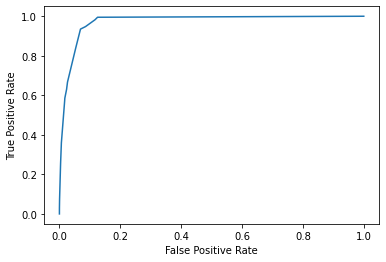

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

fpr, tpr, _ = roc_curve(y_test, pred, pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

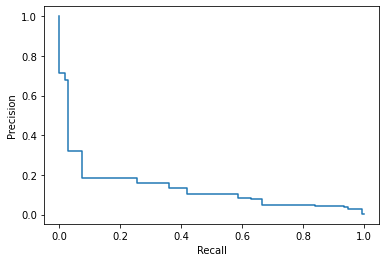

In [19]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(y_test, pred, pos_label= 1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

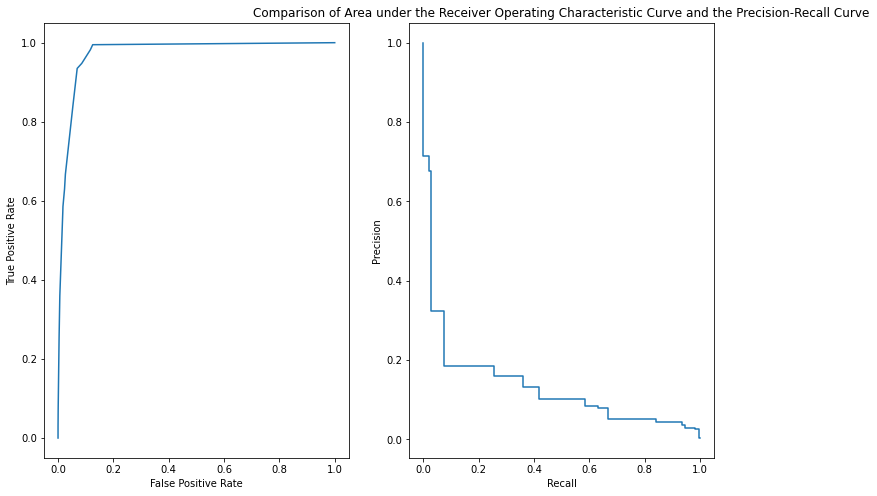

In [20]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.title("Comparison of Area under the Receiver Operating Characteristic Curve and the Precision-Recall Curve")
plt.show()
fig.savefig(os.join(plots, 'auc_precision_recall.png'))

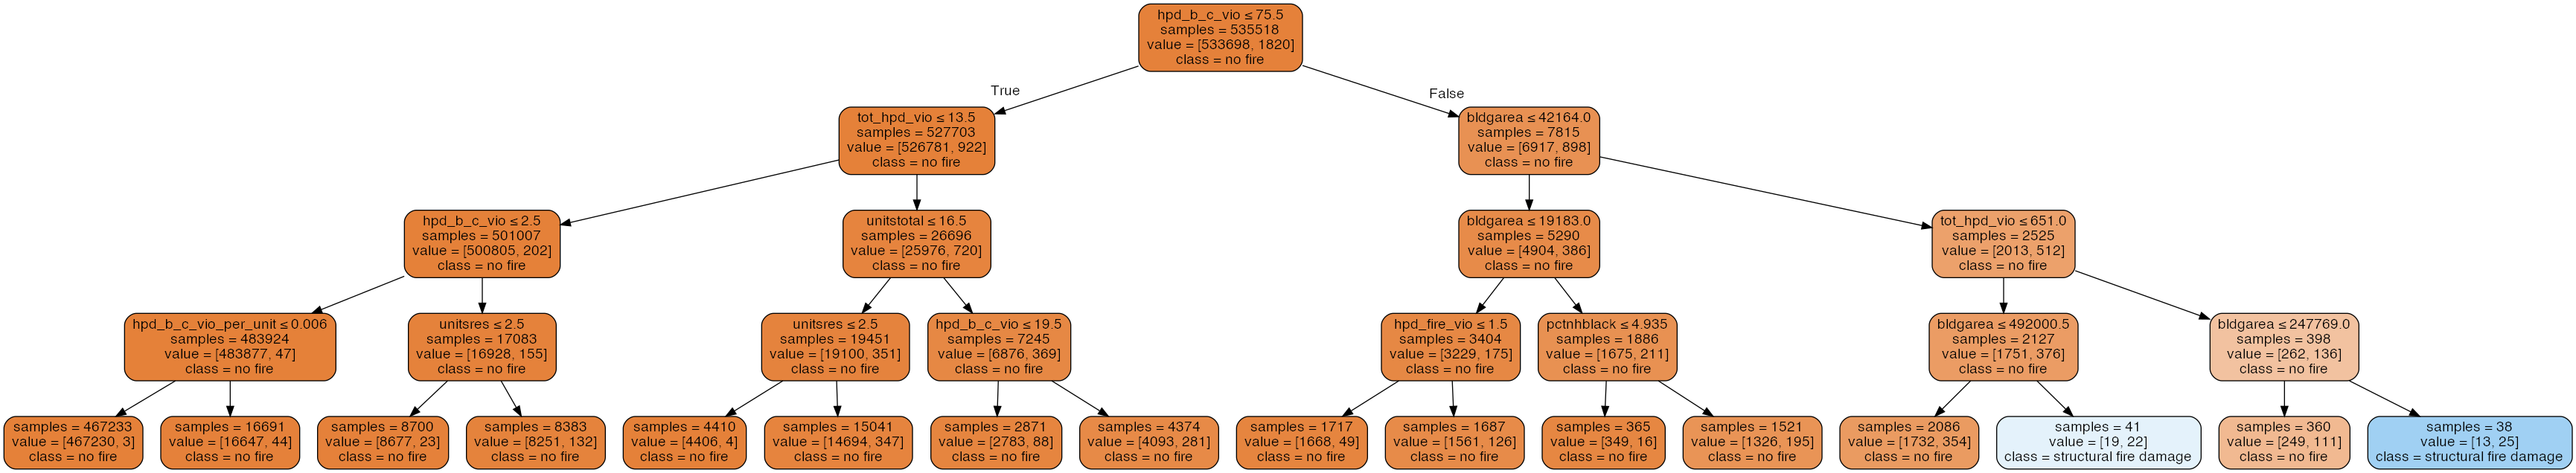

In [27]:
from sklearn import tree
from IPython.display import Image  
import pydotplus

# visualize the tree
dt = DecisionTreeClassifier(max_depth= rs.best_params_['max_depth'])
dt.fit(X_train, y_train)

thestring = tree.export_graphviz(dt, out_file=None,  
                         feature_names=X_train.columns.values, 
                         class_names=['no fire','structural fire damage'],  
                         filled=True, rounded=True,  
                         special_characters=True,impurity=False).replace(" ;\n}", " ;}")
graph = pydotplus.graph_from_dot_data(thestring);
graph.write_png(os.join(plots,'num_fire_ev_dt_bbl.png'))
Image(graph.create_png())

## Feature Importance

In [28]:
dt = DecisionTreeClassifier(max_depth=rs.best_params_['max_depth'])
dt.fit(X_train, y_train)
Feature_importance=pd.DataFrame([list(X_train.columns),list(dt.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top 10 most important features in order
ft= Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,:]
ft.to_csv(os.join(interm, 'feature_importance_bbl.csv'))
ft

,variables,importance
15,hpd_b_c_vio,0.554119
1,bldgarea,0.233007
13,tot_hpd_vio,0.146877
5,unitstotal,0.031046
4,unitsres,0.013095
64,pctnhblack,0.011394
14,hpd_fire_vio,0.009856
18,hpd_b_c_vio_per_unit,0.000606
0,lotarea,0.0
54,mediangrossrent,0.0


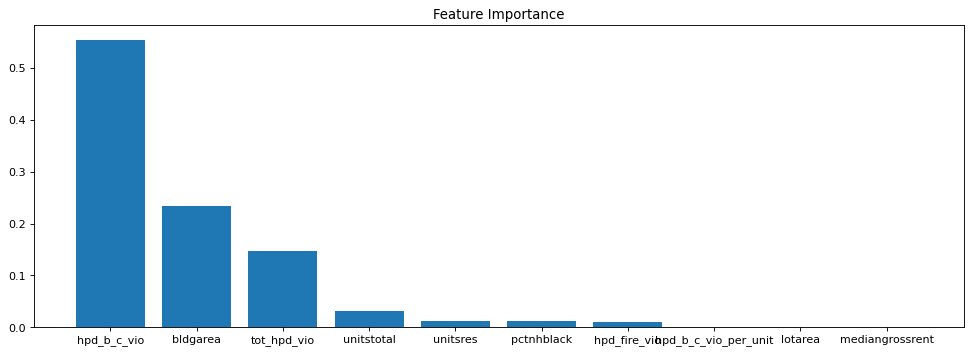

In [29]:
plt.figure(figsize=(15, 5), dpi=80)
plt.bar(Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,0],
        Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,1])
plt.title("Feature Importance");
plt.savefig(os.join(plots, 'feature_importance_bbl.png'))

## Random Forests

In [30]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=30, n_jobs=-1,max_leaf_nodes=10)
rf.fit(X_train, y_train)
pred=rf.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test,pred))

0.9749015244377949


In [ ]:
param_grid = {'max_depth':range(1,50)}
rf = RandomForestClassifier(n_jobs=-1, n_estimators = 30)
gs = GridSearchCV(rf, param_grid=param_grid, scoring='roc_auc')
rs = gs.fit(X_train,y_train)
pred=rs.predict_proba(X_test)[:,1]
print(rs.best_params_)
print(roc_auc_score(np.array(y_test),pred))

In [ ]:
rf = RandomForestClassifier(n_estimators=30, n_jobs=-1, rs.best_params['max_depth'])
rf.fit(X_train, y_train)
pred=rf.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test,pred))

In [ ]:
## look at precision and recall rates
precision_recall_fscore_support(y_test, (pred > 0.5))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

fpr, tpr, _ = roc_curve(y_test, pred, pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1)

prec, recall, _ = precision_recall_curve(y_test, pred, pos_label= 1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax2)

plt.show()
fig.savefig(os.join(plots, 'auc_precision_recall2.png'))

### CMM and other ensembles

In [ ]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=30, random_state = 99, max_depth = rs.best_params_['max_depth'])
rf.fit(X_train,y_train)

# randomly generate a sample of xs
X_rand= pd.DataFrame({x:X_train[x].sample(n = round(0.25*X_train.shape[0])).reset_index(drop = True) for x in X_train.columns})
y_rand= rf.predict(X_rand)

In [ ]:
# create the cmm training datasets
X_train_cmm= pd.concat([X_rand, X_train], axis = 0, ignore_index = True)
y_train_cmm= pd.concat([pd.DataFrame(y_rand), y_train], axis = 0, ignore_index = True)

In [ ]:
param_grid = {'max_depth':range(1,30)}
dt=DecisionTreeClassifier()
gr=GridSearchCV(dt,param_grid=param_grid, scoring='roc_auc')
rs=gr.fit(X_train_cmm,y_train_cmm)
print(rs.best_params_)
print(roc_auc_score(np.array(y_test),rs.predict_proba(X_test)[:,1]))

In [ ]:
# predict_proba predicts the probability of each class rather than just the most likely class
pred=gr.predict_proba(X_test)[:,1] # predicted probability of y = 1

print("ROC AUC:", roc_auc_score(np.array(y_test),pred))
## look at precision and recall rates
pr= precision_recall_fscore_support(y_test, pred > 0.5)
print("Precision:", pr[0][1])
print("Recall:", pr[1][1])

In [ ]:
dt = DecisionTreeClassifier(max_depth= rs.best_params_['max_depth'])
dt.fit(X_train_cmm, y_train_cmm)

thestring = tree.export_graphviz(dt, out_file=None,  
                         feature_names=X_train.columns.values, 
                         class_names=['no weapon found','weapon found'],  
                         filled=True, rounded=True,  
                         special_characters=True,impurity=False).replace(" ;\n}", " ;}")
graph = pydotplus.graph_from_dot_data(thestring);
graph.write_png(os.join(plots,'num_fire_ev_cmm.png'))
Image(graph.create_png())

## (2) Bayes Nets

In [44]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score, BicScore, BDeuScore
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
import matplotlib.pyplot as plt

In [40]:
impt_vars= ["vacate_ind"] + ft["variables"].tolist()
impt_vars

['vacate_ind',
 'hpd_b_c_vio',
 'bldgarea',
 'tot_hpd_vio',
 'unitstotal',
 'pop65plus',
 'unitsres',
 'pctnhblack',
 'hpd_fire_vio',
 'hpd_b_c_vio_per_unit',
 'mediangrossrent']

vacate_ind
hpd_b_c_vio


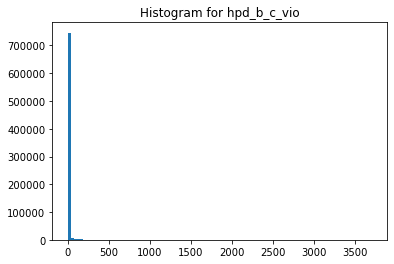

None
bldgarea


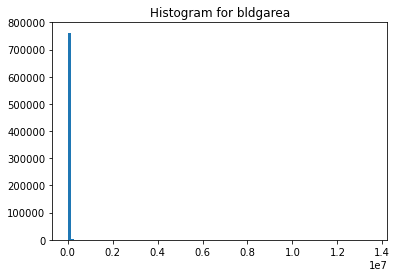

None
tot_hpd_vio


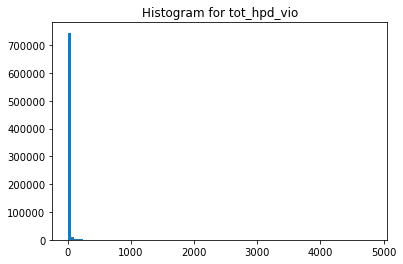

None
unitstotal


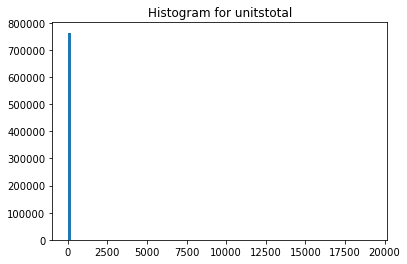

None
pop65plus


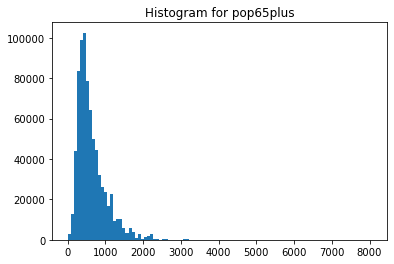

None
unitsres


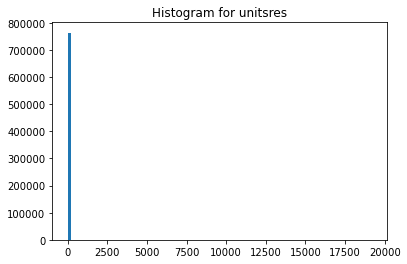

None
pctnhblack


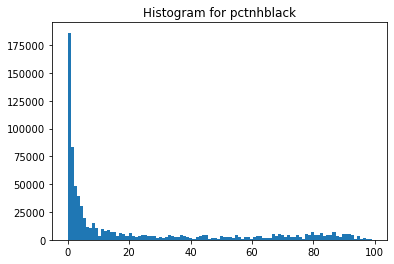

None
hpd_fire_vio


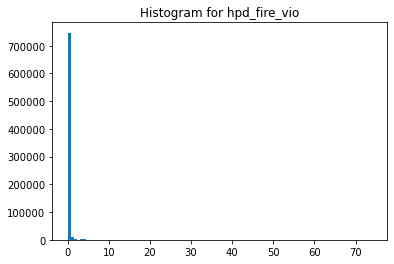

None
hpd_b_c_vio_per_unit


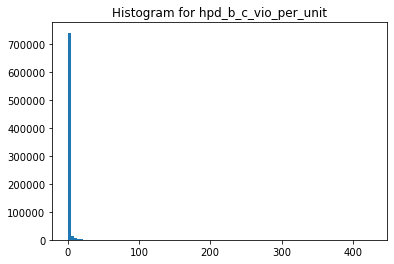

None
mediangrossrent


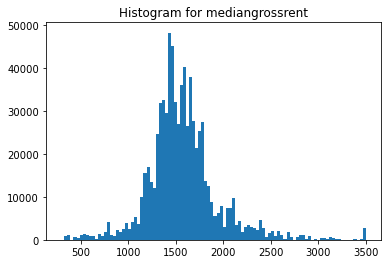

None


In [41]:
df_bbl_disc= df_bbl.copy()
# need to discretize the data, also look at distributions
for i in impt_vars:
    print(i)
    if len(df_bbl_disc.loc[:, i].unique()) > 5:
        plt.hist(df_bbl_disc.loc[:, i], bins = 100);
        plt.title("Histogram for {}".format(i))
        print(plt.show())
        df_bbl_disc.loc[:, i] = pd.qcut(df_bbl_disc.loc[:, i], q=4, labels=False, duplicates = 'drop')

In [66]:
# create test train split for testing DAG
train, test = train_test_split(df_bbl_disc.loc[:, impt_vars], test_size=0.3, random_state=999)

In [67]:
# use hill climb search with BIC score, as in hw
hc = HillClimbSearch(train)
best_model = hc.estimate(scoring_method=BicScore(train))
print("\nDAG model edges:")
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]


DAG model edges:
[('bldgarea', 'mediangrossrent'), ('bldgarea', 'pop65plus'), ('bldgarea', 'pctnhblack'), ('bldgarea', 'vacate_ind'), ('unitstotal', 'bldgarea'), ('unitstotal', 'mediangrossrent'), ('unitstotal', 'pop65plus'), ('unitstotal', 'pctnhblack'), ('pop65plus', 'mediangrossrent'), ('unitsres', 'unitstotal'), ('unitsres', 'vacate_ind'), ('unitsres', 'bldgarea'), ('pctnhblack', 'mediangrossrent'), ('pctnhblack', 'pop65plus'), ('mediangrossrent', 'vacate_ind')]


In [68]:
print("DAG model nodes:")
print(best_model.nodes())

DAG model nodes:
['vacate_ind', 'hpd_b_c_vio', 'bldgarea', 'tot_hpd_vio', 'unitstotal', 'pop65plus', 'unitsres', 'pctnhblack', 'hpd_fire_vio', 'hpd_b_c_vio_per_unit', 'mediangrossrent']


In [80]:
# look at the CPD for the model
model = BayesianNetwork(best_model.edges())
model.fit(train.loc[:, impt_vars], estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
for n in model.nodes():
    print(model.local_independencies(n))

CPD of bldgarea:
+-------------+---------------------+-----+---------------+---------------+----------------------+
| unitsres    | unitsres(0)         | ... | unitsres(2)   | unitsres(2)   | unitsres(2)          |
+-------------+---------------------+-----+---------------+---------------+----------------------+
| unitstotal  | unitstotal(0)       | ... | unitstotal(0) | unitstotal(1) | unitstotal(2)        |
+-------------+---------------------+-----+---------------+---------------+----------------------+
| bldgarea(0) | 0.5190231670483756  | ... | 0.25          | 0.25          | 0.005033827958534735 |
+-------------+---------------------+-----+---------------+---------------+----------------------+
| bldgarea(1) | 0.3086234566428266  | ... | 0.25          | 0.25          | 0.035474790727714096 |
+-------------+---------------------+-----+---------------+---------------+----------------------+
| bldgarea(2) | 0.12050383545105198 | ... | 0.25          | 0.25          | 0.20534443478983

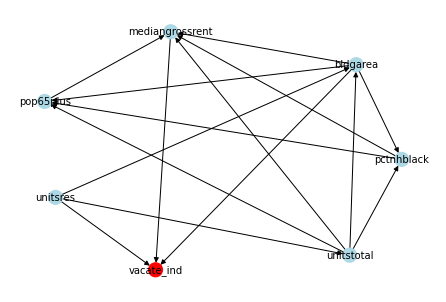

<Figure size 864x720 with 0 Axes>

In [81]:
import networkx as nx
import pylab as plt
fig = plt.gcf()

values = ['red' if n in ['vacate_ind'] else 'lightblue' for n in model.nodes()]
# use networkx to draw DAG
nx.draw(model, node_color=values, with_labels=True, font_color='black', node_size=200,font_size=10)

plt.figure(figsize = (12,10))
fig.savefig('dag_bbl.png')

In [112]:
df_bbl.loc[df_bbl.loc[:, "mediangrossrent"].isna(), ["boroct2010", "mediangrossrent", "totpop"]]

df_bbl.loc[df_bbl["boroct2010"].str.contains("None")]

ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [105]:
pred = model.predict(df_bbl_disc.loc[:, ["bldgarea", "unitstotal", "mediangrossrent"]])
print(pred)

  0%|          | 0/59 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# calc out of sample accuracy
print("\nOS accuracy for vacate orders")
print((pred == test['vacate_ind'].reset_index(drop = True)).mean())

# Anomaly Detection

## Isolation forests

In [113]:
from sklearn.ensemble import IsolationForest

# generate outliers
X_outliers= X.loc[X.loc[y==1].index, :]
X_reg= X.loc[X.loc[y==0].index, :]
# generate test and train data
X_train, X_test= train_test_split(X_reg, test_size=0.3, random_state=999)

# fit the model
if_clf = IsolationForest(max_samples=100, random_state=99)
if_clf.fit(X_train)
y_pred_train = if_clf.predict(X_train)
y_pred_test = if_clf.predict(X_test)
y_pred_outliers = if_clf.predict(X_outliers)

In [114]:
print("Percent training classified as inliers:", np.mean(y_pred_train==1))
print("Percent test data classified as inliers:", np.mean(y_pred_test==1))
print("Percent outliers classified as inliers:", np.mean(y_pred_outliers==1))

Percent training classified as inliers: 0.913049751169205
Percent test data classified as inliers: 0.9122101360568011
Percent outliers classified as inliers: 0.2434715821812596


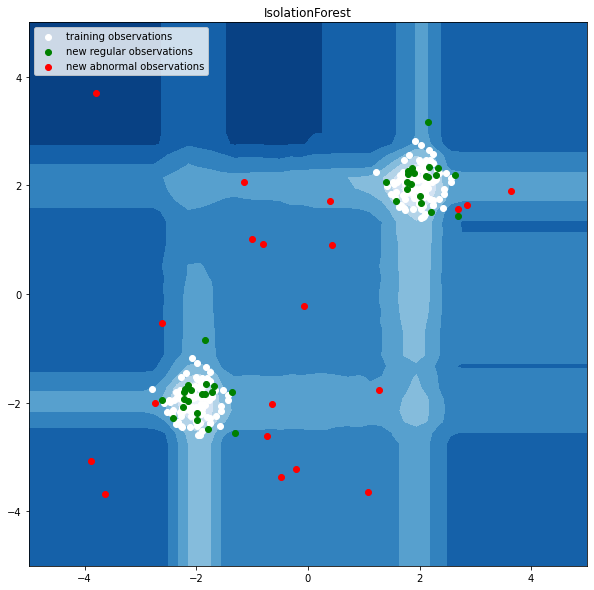

In [95]:
rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,10))

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

In [113]:
df_bbl

,borough,bbl,cd,tract2010,zipcode,address,bldgclass,landuse,ownertype,ownername,...,pctnhasian,pctnhhawainpi,pctnhother,pctnhtwoplus,pctownerocch,pctrentocch,crowding,crowdingrenter,medianhhincome_imp,geofips_recode
0,MN,1.012090e+09,107.0,181.0,10025.0,7 WEST 95 STREET,C2,2.0,NaN,ROBERT & ANNE RABBINO,...,6.191149,0.0,1.483051,2.106874,32.879925,67.120075,2.532833,3.773585,0.0,1018100.0
1,MN,1.012090e+09,107.0,181.0,10025.0,5 WEST 95 STREET,C5,2.0,NaN,"5 WEST 95TH STREET,",...,6.191149,0.0,1.483051,2.106874,32.879925,67.120075,2.532833,3.773585,0.0,1018100.0
2,MN,1.012090e+09,107.0,181.0,10025.0,12 WEST 96 STREET,D4,3.0,NaN,12 W 96TH STREET CORP,...,6.191149,0.0,1.483051,2.106874,32.879925,67.120075,2.532833,3.773585,0.0,1018100.0
3,MN,1.012090e+09,107.0,181.0,10025.0,44 WEST 96 STREET,D4,3.0,NaN,44 OWNERS CORP,...,6.191149,0.0,1.483051,2.106874,32.879925,67.120075,2.532833,3.773585,0.0,1018100.0
4,MN,1.012090e+09,107.0,181.0,10025.0,46 WEST 96 STREET,D4,3.0,NaN,46 W 96TH ST OWNERS CORP,...,6.191149,0.0,1.483051,2.106874,32.879925,67.120075,2.532833,3.773585,0.0,1018100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765023,MN,1.001110e+09,103.0,25.0,10038.0,20 MADISON STREET,D6,4.0,O,NYC HOUSING AUTHORITY,...,39.595112,0.0,0.000000,5.362028,0.000000,100.000000,10.834897,10.834897,0.0,1002500.0
765024,MN,1.003250e+09,103.0,1002.0,10002.0,140 BARUCH PLACE,C4,2.0,O,NYC HOUSING AUTHORITY,...,18.828776,0.0,0.000000,1.144076,0.000000,100.000000,1.210165,1.210165,0.0,1001002.0
765025,MN,1.003230e+09,103.0,1002.0,10002.0,288 DELANCEY STREET,D3,3.0,O,NYC HOUSING AUTHORITY,...,18.828776,0.0,0.000000,1.144076,0.000000,100.000000,1.210165,1.210165,0.0,1001002.0
765026,MN,1.003560e+09,103.0,20.0,10009.0,10 AVENUE D,D3,3.0,O,NYC HOUSING AUTHORITY,...,21.718273,0.0,0.000000,1.548190,0.356415,99.643585,6.517312,6.540623,0.0,1002000.0
